In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

In [2]:
# Read and format data
path = 'data/combined_data_new.csv'
df_all = pd.read_csv(path)

df_all.date_time_current = pd.to_datetime(df_all.date_time_current, format = "%Y-%m-%d %H:%M:%S")
df_all.date_time_future = pd.to_datetime(df_all.date_time_future, format = "%Y-%m-%d %H:%M:%S")
df_all.date_time_current_rounded = pd.to_datetime(df_all.date_time_current_rounded, format = "%Y-%m-%d %H:%M:%S")

df_all["forecast_interval"] = df_all.date_time_future - df_all.date_time_current_rounded
df_all["forecast_error"] = df_all.total_demand - df_all.forecast_demand

df_all["forecast_error_relative"] = df_all.forecast_error/df_all.total_demand

df_all["date_time_future_month"] = df_all.date_time_future.dt.month
df_all["date_time_future_year"] = df_all.date_time_future.dt.year
df_all["date_time_future_weekday"] = df_all.date_time_future.dt.dayofweek
df_all["date_time_future_yearTime"] = df_all.date_time_future_year.apply(lambda x: pd.DateOffset(years=x-2000))
df_all["date_time_future_hour"] = df_all.date_time_future.dt.hour

In [3]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

ADF Statistic: -33.406571
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


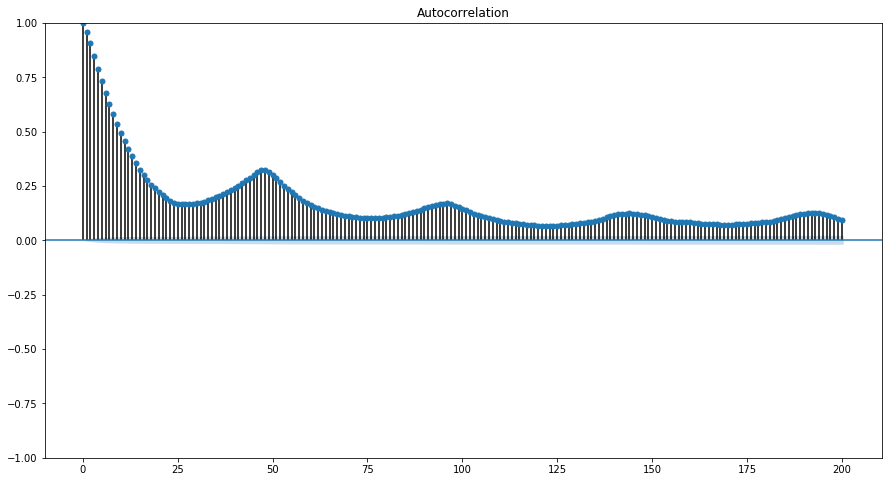

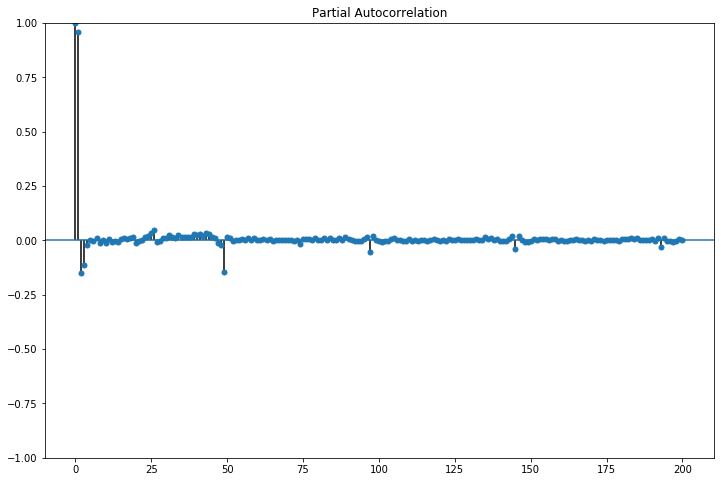

In [4]:
period_id = 24
year_portion = 0.1

fig, ax = plt.subplots(figsize = (15, 8))
df_all_delta = df_all.loc[df_all.period_id == period_id].sort_values("date_time_future").reset_index(drop = True)

check_stationarity(df_all_delta.forecast_error_relative)

plot_acf(df_all_delta.forecast_error_relative, lags = 200, ax = ax)
plt.show()
plt.rcParams["figure.figsize"] = (12, 8)

plot_pacf(df_all_delta.forecast_error_relative, lags = 200)
plt.show()
plt.rcParams["figure.figsize"] = (12, 8)

## Timeseries - 1 hour of day

ADF Statistic: -5.875132
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Stationary


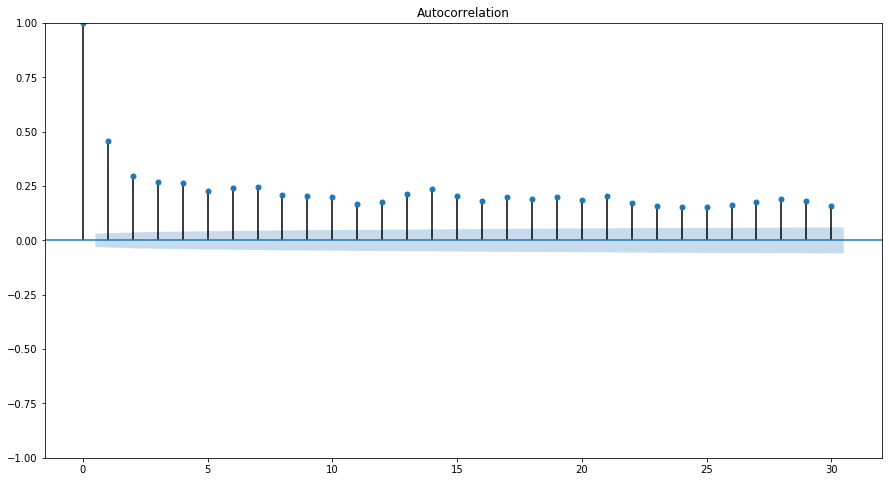

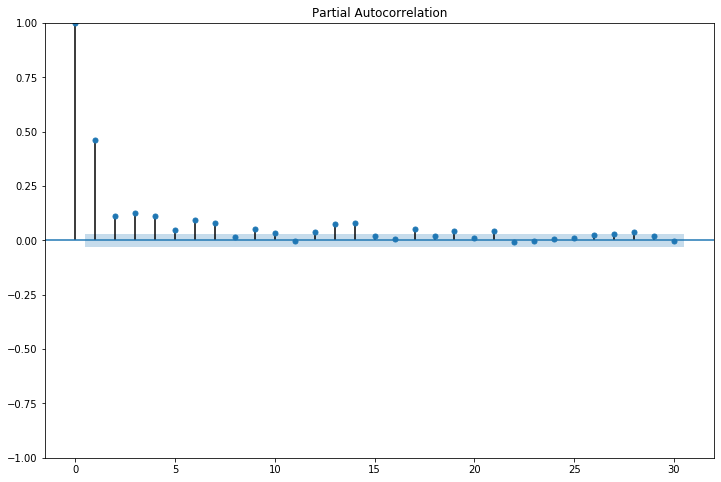

In [5]:
period_id = 24
hour_of_day = 4

fig, ax = plt.subplots(figsize = (15, 8))
df_all_delta = df_all.loc[(df_all.period_id == period_id) & (df_all.date_time_future_hour == hour_of_day) & (df_all.date_time_future.dt.minute == 0)].sort_values("date_time_future").reset_index(drop = True)

check_stationarity(df_all_delta.forecast_error_relative)

plot_acf(df_all_delta.forecast_error_relative, lags = 30, ax = ax)
plt.show()
plt.rcParams["figure.figsize"] = (12, 8)

plot_pacf(df_all_delta.forecast_error_relative, lags = 30)
plt.show()
plt.rcParams["figure.figsize"] = (12, 8)

SARIMA models considered:
- order=(1,0,0), seasonal_order=(0, 0, 0, 0) 
- order=(1,0,1), seasonal_order=(0, 0, 0, 0) 
- order=(7,0,1), seasonal_order=(0, 0, 0, 0)
- order=(7,0,7), seasonal_order=(0, 0, 0, 0)
- order=(1,0,0), seasonal_order=(1, 0, 1, 7)
- order=(6,0,2), seasonal_order=(1, 0, 1, 7) ## My preference
- order=(6,0,2), seasonal_order=(1, 0, 2, 7)
- order=(6,0,1), seasonal_order=(2, 0, 1, 7)
- order=(2,0,1), seasonal_order=(2, 0, 1, 7) 

In [6]:
sarimas = pd.DataFrame({"order":[(1,0,0), (1,0,1), (7,0,1), (7,0,7), (1,0,0), (6,0,2), (6,0,2), (6,0,1), (2,0,1)],
                        "seasonal_order": [(0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (0, 0, 0, 0), (1, 0, 1, 7), (1, 0, 1, 7), (1, 0, 2, 7), (2, 0, 1, 7), (2, 0, 1, 7)]})
sarimas = sarimas.reset_index().rename({"index": "id"}, axis = 1)

columns = ["sarima_id", "hour_of_day", "order", "seasonal_order", "ljung_val", "ljung_p", "jb_val", "jb_p", "hetro_val", "hetro_p", "skew", "kurtosis", "aic", "bic", "n_observations", "mse_pre", "mse_post"]
sarima_tune = pd.DataFrame(columns = columns)

period_id = 24

hours_all = [0, 4, 8, 12, 16, 20]

for hour_of_day in hours_all:
    for index, row in sarimas.iterrows():
        order = row["order"]
        seasonal_order = row["seasonal_order"]
        sarima_id = row["id"]

        df_all_delta = df_all.loc[(df_all.period_id == period_id) & (df_all.date_time_future_hour == hour_of_day) & (df_all.date_time_future.dt.minute == 0)].sort_values("date_time_future").reset_index(drop = True)

        # Model fit
        model = ARIMA(df_all_delta.forecast_error, order = order, seasonal_order = seasonal_order)
        model_fit = model.fit()
        df_all_delta["predicted_forecast_error"] = model_fit.fittedvalues
        df_all_delta["new_forecast"] = df_all_delta.forecast_demand + df_all_delta.predicted_forecast_error

        # Model Evaluation (MSE)
        mse_pre = mean_squared_error(df_all_delta.total_demand,df_all_delta.forecast_demand)
        mse_post = mean_squared_error(df_all_delta.total_demand,df_all_delta.new_forecast)

        # Model Evaluation (Crit values)
        stat_tests = pd.read_html(model_fit.summary().tables[2].as_html(),header=None,index_col=0)[0]
        ljung_val, ljung_p = stat_tests[1].iloc[0], stat_tests[1].iloc[1], 
        jb_val, jb_p = stat_tests[3].iloc[0], stat_tests[3].iloc[1], 
        hetro_val, hetro_p = stat_tests[1].iloc[2], stat_tests[1].iloc[3], 
        skew, kurtosis = stat_tests[3].iloc[2], stat_tests[3].iloc[3]

        # Model Evaluation (AIC, BIC)
        stat_tests = pd.read_html(model_fit.summary().tables[0].as_html(),header=None,index_col=0)[0]
        aic, bic = stat_tests[3].iloc[2], stat_tests[3].iloc[3]
        n_observations = stat_tests[3].iloc[0]
        sarima_tune = sarima_tune.append(pd.DataFrame([[sarima_id, hour_of_day, order, seasonal_order, ljung_val, ljung_p, jb_val, jb_p, hetro_val, hetro_p, skew, kurtosis, aic, bic, n_observations, mse_pre, mse_post]], columns=columns), ignore_index=True)

(0, 30)

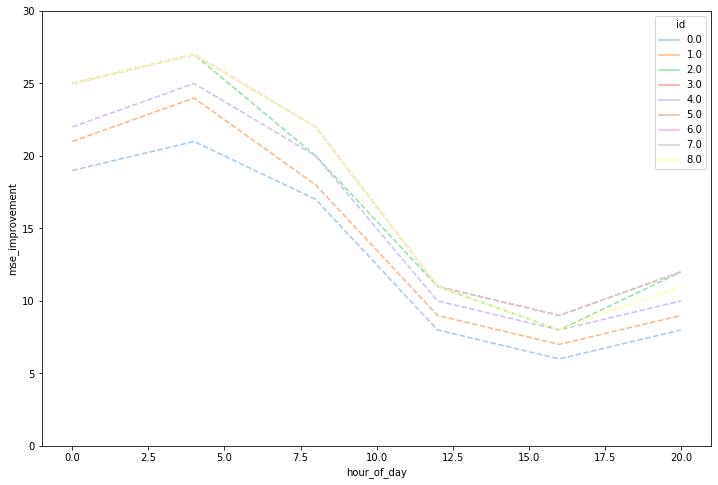

In [7]:
#sarima_tune = pd.read_csv("data/sarima_tune.csv")
sarima_tune["mse_improvement"] = round(100*(sarima_tune.mse_pre - sarima_tune.mse_post)/sarima_tune.mse_pre)
sarima_tune = pd.merge(sarima_tune, sarimas, on = ["order", "seasonal_order"], how = "left").sort_values("id")

plot = sarima_tune.groupby(["order", "seasonal_order", "hour_of_day"], as_index = False).mean()
sns.lineplot(data = plot, x = 'hour_of_day', y = 'mse_improvement', hue = 'id', palette = 'pastel', alpha = 1, linestyle = '--')
plt.ylim(0, 30)

#### Note
5, 6, 7 have same MSE improvement and are the best
order=(6,0,2), seasonal_order=(1, 0, 1, 7) prefered as lowest complexity of 5, 6, 7